## Implementation of Neural network from scratch

### Based on http://neuralnetworksanddeeplearning.com/chap2.html

In [115]:
import numpy as np
from statistics import mean 
import pandas as pd
import numpy.random as r
from random import randrange
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [119]:
# define XOR training data
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
])
y = np.atleast_2d([0, 1, 1, 0]).T

In [116]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))

def cost(y_hat, y):
    return np.mean([_ * _ for _ in (y_hat - y)])


In [117]:
def init_net(inputSize, layers, outputSize):
    input_size = inputSize
    output_size = outputSize
    params , metadata ,theta = {},{},{}
    metadata["inputSize"] = input_size
    metadata["outputSize"] = output_size
    metadata["n_layers"] = layers
    params["metadata"] = metadata 
    for idx in range(0, layers):
        if idx!=layers-1:
            theta["W_" + str(idx)] = r.rand(input_size, input_size)
            theta["B_" + str(idx)] = np.array([r.rand(input_size)]).T
        else:
            theta["W_" + str(idx)] = r.rand(outputSize,input_size)
            theta["B_" + str(idx)] = np.array([r.rand(outputSize)]).T
    params["theta"] = theta
    return params

In [209]:
def forwardPass(x,y,params):
    L = params["metadata"]["n_layers"]
    theta = params["theta"]
    forward = {}
    for idx in range(0,L):
        if idx == 0:
            data_in = np.array([x]).T
            w,i = params["theta"]["W_"+str(idx)],data_in
            z = (np.matmul(w,i))+params["theta"]["B_"+str(idx)]
            a = sigmoid(z)
            forward["Z_"+str(idx)] = z
            forward["A_"+str(idx)] = a
            forward["A_prev"+str(idx)] = data_in
        else:
            w,i = params["theta"]["W_"+str(idx)],a
            forward["A_prev"+str(idx)] = a
            z = (np.matmul(w,i))+params["theta"]["B_"+str(idx)]
            a = sigmoid(z)
            forward["Z_"+str(idx)] = z
            forward["A_"+str(idx)] = a
    forward["error"] = np.subtract(y,a)/params["metadata"]["outputSize"]
    params["forwardPass"] = forward  
    return params

In [210]:
params = forwardPass(X[1],y[1],params)

### 1. Back propogation

In [211]:
def backPropogation(params,lr,update=True, debug=False):
    L = params["metadata"]["n_layers"]
    params["metadata"]["learningRate"] = lr
    finalLayer = True
    deltas = {}
    d_theta = {}
    for l in reversed(range(0,L)):
        if finalLayer:
            a_prev = params["forwardPass"]["A_prev"+str(l)].reshape(1,-1)
            delta = -params["forwardPass"]["error"]*sigmoid_prime(params["forwardPass"]["Z_"+str(l)])
            deltas["delta_"+str(l)] = delta
            dw = np.matmul(delta,a_prev)
            d_theta["d_theta_"+str(l)] = dw
            
            if update:
                params["theta"]["W_"+str(l)] -= params["metadata"]["learningRate"]*dw
                params["theta"]["B_"+str(l)] -= params["metadata"]["learningRate"]*delta
            if debug:
                print(delta, dw)
            finalLayer = False
        else:
            a_prev = params["forwardPass"]["A_prev"+str(l)].reshape(1,-1)
            w_next = params["theta"]["W_"+str(l+1)].T
            delta = np.matmul(w_next,delta)*sigmoid_prime(params["forwardPass"]["Z_"+str(l)])
            deltas["delta_"+str(l)] = delta
            dw = np.matmul(delta,a_prev)
            d_theta["d_theta_"+str(l)] = dw
            if update:
                params["theta"]["W_"+str(l)] -= params["metadata"]["learningRate"]*dw
                params["theta"]["B_"+str(l)] -= params["metadata"]["learningRate"]*delta
            if debug:
                print(delta)
    params["deltas"] = deltas
    params["d_theta"] = d_theta
    
    return params

In [213]:
var = init_net(2, 2, 1)
epochs = 10000
epoch_error = []

for i in range(0,epochs):
    item = randrange(0,3)
    var = forwardPass(X[item],y[item],var)
    var = backPropogation(var,0.125, debug=False)
    c = 0.5*(var["forwardPass"]["error"])**2
    epoch_error.append(c)
    

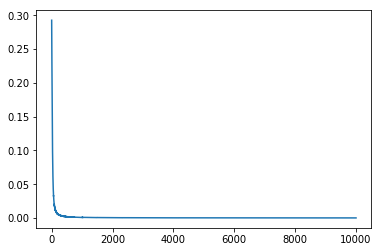

In [214]:
plt.plot(np.squeeze(epoch_error))
plt.show()

### Grad Check

In [215]:
params = init_net(2,3,1)
pm = forwardPass(X[1], y[1], params)
pm = backPropogation(pm,0.125,update=False)
epsilon = 1e-4

In [216]:
grad_check = np.zeros(params["theta"]['W_2'].shape)
for i in range(0,params["theta"]['W_2'].shape[0]):
    for j in range(0,params["theta"]['W_2'].shape[1]):
        params["theta"]['W_2'][i][j] = params["theta"]['W_2'][i][j]+epsilon
        p = forwardPass(X[1], y[1], params)
        s = np.array(p["forwardPass"]["error"])
        j_plus = s.dot(s)/2
        
        params["theta"]['W_2'][i][j] = params["theta"]['W_2'][i][j]-2*epsilon
        p = forwardPass(X[1], y[1], params)
        s = np.array(p["forwardPass"]["error"])
        j_minus = s.dot(s)/2
        grad_check[i][j] = (j_plus - j_minus)/ (2*epsilon)
        params["theta"]['W_2'][i][j] = params["theta"]['W_2'][i][j]+epsilon
        
print("grad Check",grad_check)
print("deltas", pm["d_theta"]['d_theta_2'])

grad Check [[0.10791287 0.11399166]]
deltas [[0.10791287 0.11399166]]


In [217]:
dataset = pd.DataFrame([[2.7810836, 2.550537003, 0],
           [1.465489372, 2.362125076, 0],
           [3.396561688, 4.400293529, 0],
           [1.38807019, 1.850220317, 0],
           [3.06407232, 3.005305973, 0],
           [7.627531214, 2.759262235, 1],
           [5.332441248, 2.088626775, 1],
           [6.922596716, 1.77106367, 1],
           [8.675418651, -0.242068655, 1],
           [7.673756466, 3.508563011, 1]])

X = dataset.values[:,0:2]
y = dataset.values[:,2]

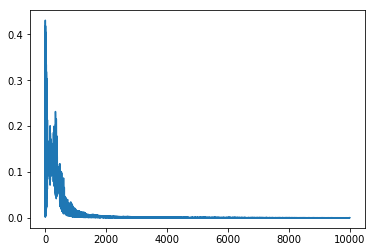

In [220]:
var = init_net(2, 2, 1)
epochs = 10000
epoch_error = []

for i in range(0,epochs):
    item = randrange(0,9)
    var = forwardPass(X[item],y[item],var)
    var = backPropogation(var,0.25, debug=False)
    c = 0.5*(var["forwardPass"]["error"])**2
    epoch_error.append(c)

plt.plot(np.squeeze(epoch_error))
plt.show()